In [1]:
import pandas as pd
from pandas import DataFrame
from datetime import datetime as dt
from datetime import timedelta 
from matplotlib import pyplot as plot
from matplotlib.dates import DateFormatter
from dotenv import load_dotenv
import yaml

with open('config/app.yaml', 'r') as file:
    APP_CONFIG = yaml.safe_load(file)

with open('config/data.yaml', 'r') as file:
    DATA_CONFIG = yaml.safe_load(file)
    
DATE_FORMATTER = DateFormatter("%d-%m-%Y")
DATE_TIME_FORMATTER = DateFormatter("%d-%m-%Y %H:%M:%S")

def read_data(path: str):
    df = pd.read_csv(path, sep=';')
    df = df.assign(date_time=pd.to_datetime(df['Timestamp']))
    df = df.assign(date=df['date_time'].map(lambda r: r.date()))
    df = df.assign(time=df['date_time'].map(lambda r: r.time()))
    df = df.assign(time_delta=df['date_time'].diff())
    df.loc[0, 'time_delta'] = timedelta()
    df = df.assign(time_delta=df['time_delta'].apply(lambda h: h.total_seconds() / 60 / 60))
    df = df.assign(time_delta_average=df['time_delta'].rolling(3).mean())
    return df


def plot_time_delta(df: DataFrame, title: str):
    time_delta_mean = round(df['time_delta'].mean(), ndigits=2)
    ax = df.plot(x="date_time", y=["time_delta","time_delta_average"], xlabel="Time", ylabel=["Hours", "Moving Avg."], marker='o')
    bx = df.plot(x="date_time", y=["time_delta_average"], xlabel="Avg. Time", ylabel=["Avg. Hours"], marker='o')
    ax.xaxis.set_major_formatter(DATE_TIME_FORMATTER)
    
    plot.xticks(rotation=45, ha='right')
    ax.legend([f"Time Delta (Avg:{time_delta_mean}) Hrs"])
    ax.set_title(f"{title} Daily Time Delta Between Intake")
    ax.grid()
    plot.show()
    
def plot_daily_time_delta(df: DataFrame, title: str):
    daily_time_delta = df.groupby(['date'])['time_delta'].mean()
    ax = daily_time_delta.plot(x="date", y=["time_delta"], xlabel="Date", ylabel="Delta Hours", marker='o')
    ax.xaxis.set_major_formatter(DATE_FORMATTER)
    plot.xticks(rotation=45, ha='right')
    ax.legend([f"Time Delta By Day"])
    ax.set_title(f"{title} Time Delta Between Intake")
    ax.grid()
    plot.show()


def plot_daily_intake(df: DataFrame, title: str):
    daily_intake = df.groupby(['date'])['Dose'].sum()
    ax = daily_intake.plot(x="date", y=["Dose"], xlabel="Date", ylabel=f"{title} Dose", marker='o')
    ax.xaxis.set_major_formatter(DATE_FORMATTER)
    daily_intake_max = df.groupby(['date'])['Dose'].sum().max()
    daily_intake_min = df.groupby(['date'])['Dose'].sum().min()
    ax.legend([f"Dose (Min:{daily_intake_min}, Max:{daily_intake_max})"])
    ax.set_title(f"{title} Daily Intake")
    plot.xticks(rotation=45, ha='right')
    ax.grid()
    plot.show()
    
def plot_hourly_pain_episodes(df: DataFrame, title: str):
    hours_data = [0 for i in range(0, 24)]
    hours = ["{:02d}:00".format(i) for i in range(0, 24)]
    
    data_counts = df[df['Type'] == 'start'].groupby([lambda i: df.loc[i]['time'].hour])['Intensity'].count()

    for index in data_counts.index: 
        hours_data[index]=data_counts.loc[index]
    ax = plot.bar(hours,hours_data,label=hours)
    plot.xticks(rotation=45, ha='right')
    plot.show()
    

In [2]:
def plot_hourly_pain_intensity(df: DataFrame, title: str):
    hours_data = [0 for i in range(0, 24)]
    hours = ["{:02d}:00".format(i) for i in range(0, 24)]

    data_intensity = df.groupby([lambda i: df.loc[i]['time'].hour])['Intensity'].mean()

    for index in data_intensity.index: 
        hours_data[index] = data_intensity.loc[index]
    ax = plot.bar(hours,hours_data,label="Pain Intensity By Hour of The Day")
    plot.xticks(rotation=45, ha='right')
    plot.show()

**Intake Data**

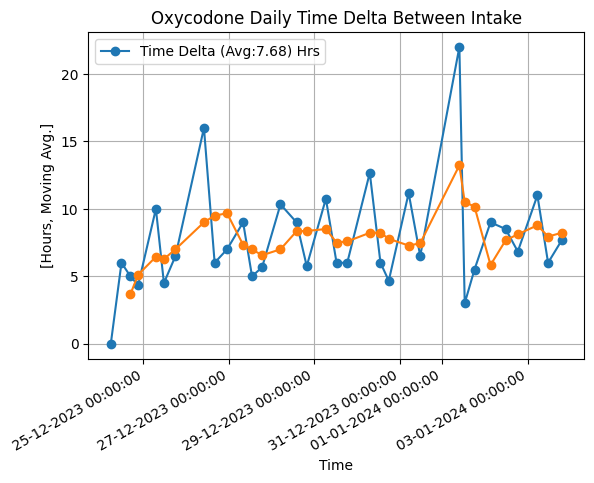

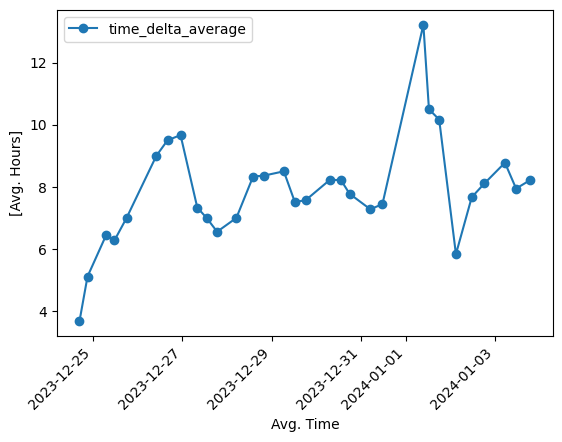

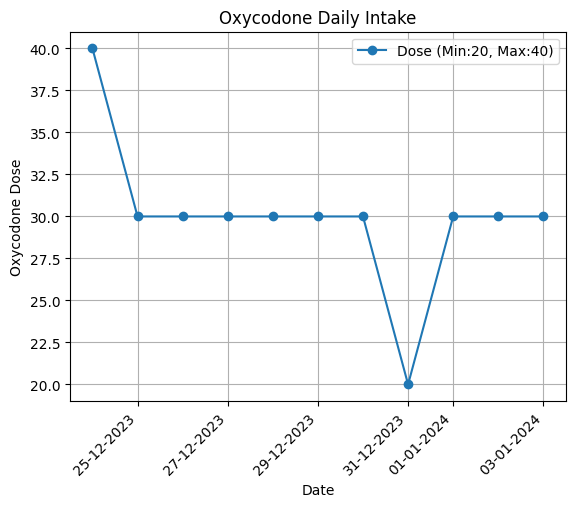

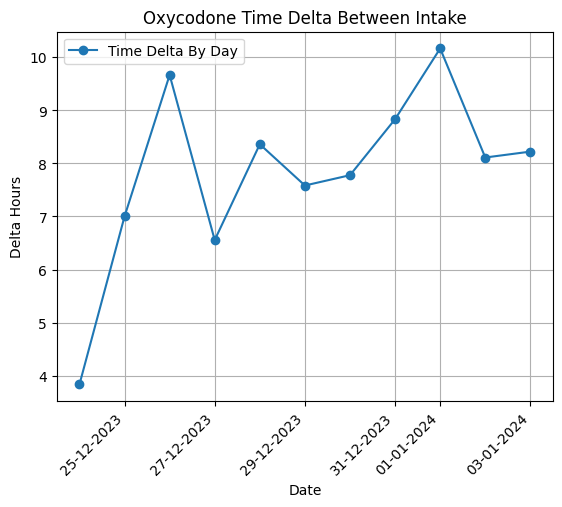

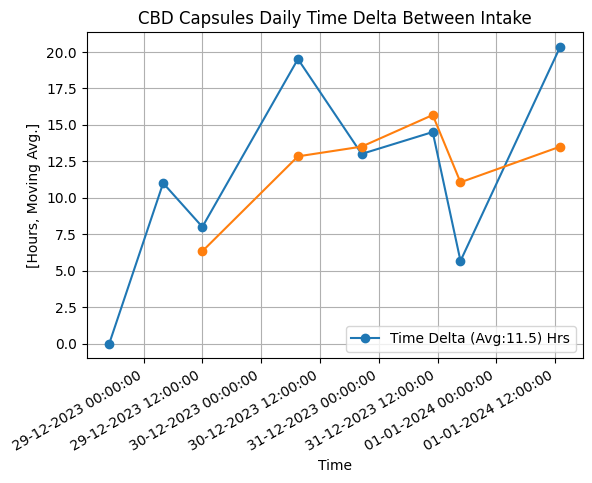

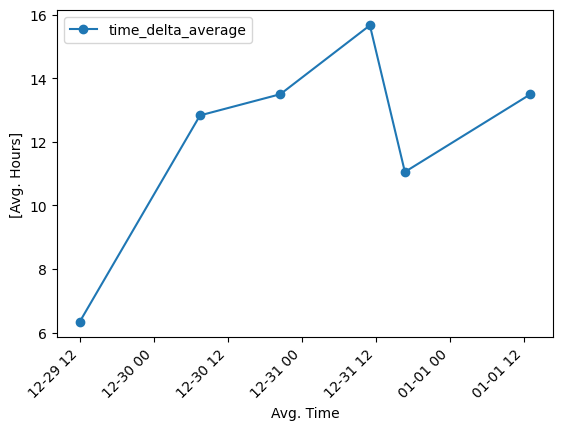

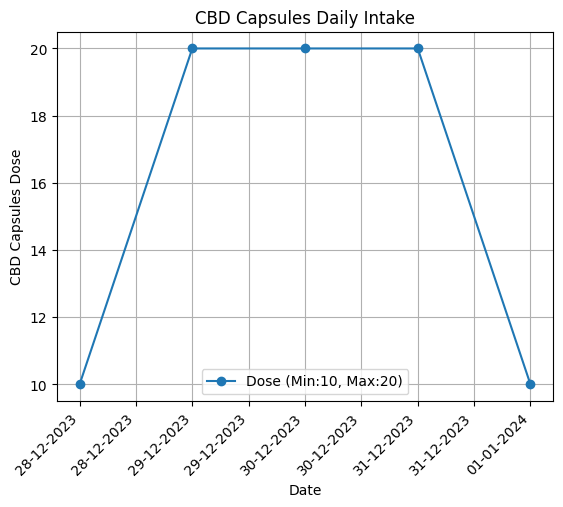

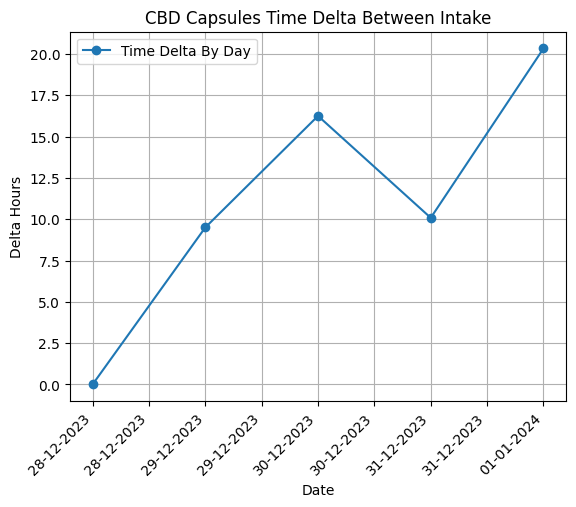

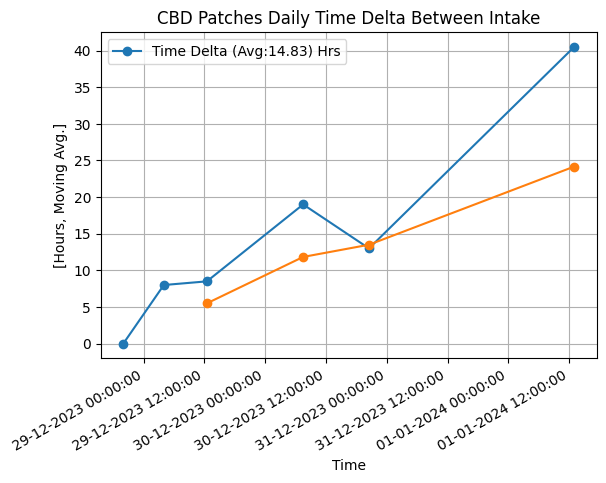

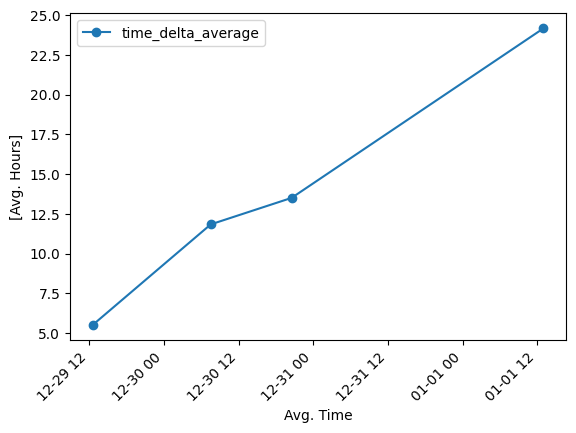

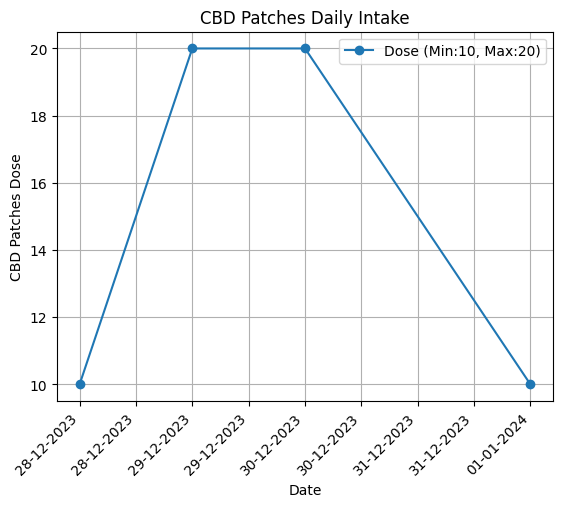

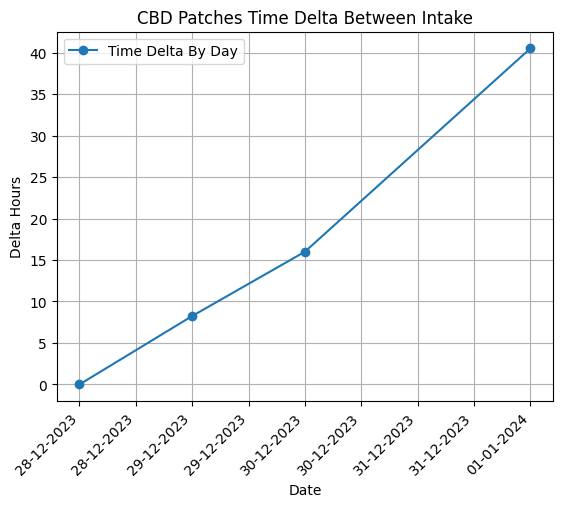

In [3]:
for data in DATA_CONFIG['medication']['data']:
    df = read_data(data['source'])
    plot_time_delta(df, data['name'])
    plot_daily_intake(df, data['name'])
    plot_daily_time_delta(df, data['name'])

**Pain Data**

**Pain Episodes By Hour Of The Day**

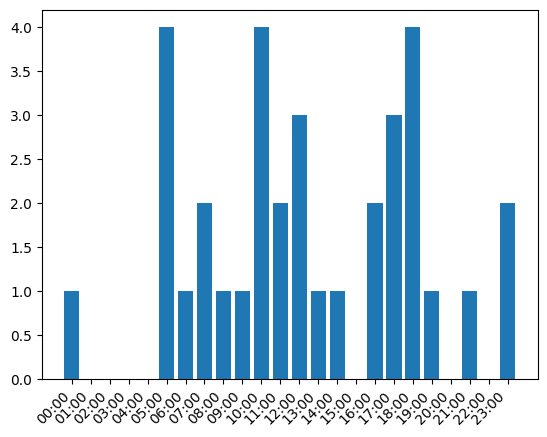

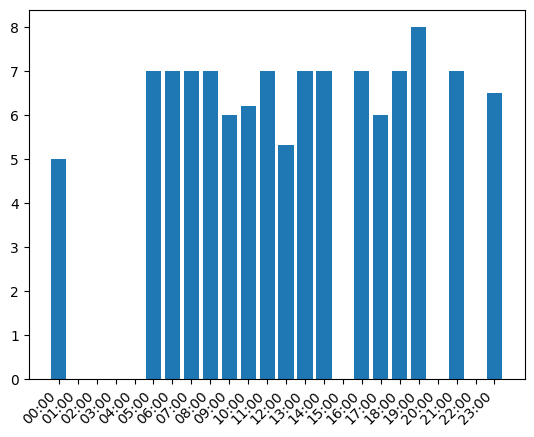

In [4]:
for data in DATA_CONFIG['pain']['data']:
    df_pain = read_data(data['source'])
    plot_hourly_pain_episodes(df_pain, data['name'])
    plot_hourly_pain_intensity(df_pain, data['name'])

**Pain Intensity By Hour Of The Day**